In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import torch
import torchvision
import collections
import math

In [9]:
base_dir = '../data/kaggle_cifar10_tiny'

In [10]:
def read_csv():
    df = pd.read_csv(os.path.join(base_dir,'trainLabels.csv'))
    label_dict = dict(zip(df['id'],df['label']))
    return label_dict
label_dict = read_csv()
n = collections.Counter(label_dict.values()).most_common()[-1][1]

In [11]:
valid_num = max(1,math.floor(n*0.1))

In [12]:
def copy_file(filename,target_dir):
    os.makedirs(target_dir,exist_ok=True)
    shutil.copy(filename,target_dir)

In [13]:
batch_size = 32
valid_ratio = 0.1

In [14]:
label_count = {}
valid_num = max(1,math.floor(n*0.1))
for filename in os.listdir(os.path.join(base_dir,'train')):
    label = label_dict[int(filename.split('.')[0])]
    fname = os.path.join(base_dir, 'train', filename)
    if  label not in label_count or label_count[label]<valid_num:
        copy_file(fname,os.path.join(base_dir,'train_valid_dir','valid',label))
        label_count[label] = label_count.get(label,0)+1
    else:
        copy_file(fname,os.path.join(base_dir,'train_valid_dir','train',label))

In [15]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64到1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [16]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [17]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(base_dir, 'train_valid_dir', folder),
    transform=transform_train) for folder in ['train', 'valid']]

In [18]:
len(train_valid_ds)

80

In [19]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [22]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [23]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [24]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [25]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [26]:
X = torch.rand(size=(1, 64, 224, 224))
for layer in b3:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Residual output shape:	 torch.Size([1, 128, 112, 112])
Residual output shape:	 torch.Size([1, 128, 112, 112])


In [27]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [28]:
loss = nn.CrossEntropyLoss(reduction="none")


In [29]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

In [30]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

train loss 0.553, train acc 0.814, valid acc 0.422
103.0 examples/sec on [device(type='mps', index=0)]


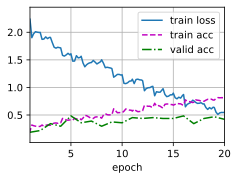

In [37]:
devices, num_epochs, lr, wd = try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, train_valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [36]:
def try_all_gpus():
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]
    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'mps:{i}')
             for i in range(1)]
    return devices if devices else [torch.device('cpu')]

In [1]:
pip uninstall torchtext

Found existing installation: torchtext 0.4.0
Uninstalling torchtext-0.4.0:
  Would remove:
    /Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torchtext-0.4.0.dist-info/*
    /Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torchtext/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [2]:
y

NameError: name 'y' is not defined